<a href="https://colab.research.google.com/github/AlexandreAdam/torch_score_models/blob/master/notebooks/two_moons_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install score_models --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.0 MB/s eta 0:00:00


In [10]:
#@title Utilities, run this cell
import torch.distributions as tfd
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
import matplotlib.pylab as pylab
import matplotlib.cm as cm
plt.style.use("dark_background")
params = {
    'legend.fontsize': 20,
    'figure.figsize': (5, 5),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 20 # for annotate
}
pylab.rcParams.update(params)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def two_moons(modes=128, width=0.1, size=1, device=DEVICE) -> tfd.Distribution:
    """
    Returns a 2 moons distributions from a mixture of <modes> gaussian distributions
    :param modes: Number of modes inside each moon
    :param width: Width of the moons
    :param size: scales the coordinates by this amount
    """
    outer_circ_x = torch.cos(torch.linspace(0, np.pi, modes)) - .5
    outer_circ_y = torch.sin(torch.linspace(0, np.pi, modes)) - .25
    inner_circ_x = - torch.cos(torch.linspace(0, np.pi, modes)) + .5
    inner_circ_y = - torch.sin(torch.linspace(0, np.pi, modes)) + .25
    x = torch.concat([outer_circ_x, inner_circ_x])
    y = torch.concat([outer_circ_y, inner_circ_y])
    coords = size * torch.stack([x, y], dim=1).to(device)
    mixture = tfd.Categorical(probs=torch.ones(2*modes).to(device), validate_args=False)  # Uniform
    component = tfd.Independent(tfd.Normal(loc=coords, scale=width, validate_args=False), 1)  # Diagonal Multivariate Normal
    return tfd.MixtureSameFamily(mixture, component, validate_args=False)


def five_swiss_rolls(modes=128, size=0.1, width=0.1, spread=0.7, offset=3, device=DEVICE):
    """
    Returns 5 swiss roll distribution arranged in the classic 5 dots pattern
        :param modes: Number of modes in the mixture
        :param size: Size of the swiss roll
        :param width: Width of the modes in the swiss roll
        :param spread: Angular spread of the modes in the swiss roll
        :param offset: Distance between the swiss rolls
    """
    assert (spread > 0)
    offsets = [[-offset, offset], [offset, -offset], [offset, offset], [-offset, -offset]]
    coords = []
    for k in range(5):
        t = 1.5 * np.pi * (1 + 2 * torch.linspace(0, 1, modes)**(spread))
        x = size * t * torch.cos(t)
        y = size * t * torch.sin(t)
        if k > 0:
            x += offsets[k-1][0]
            y += offsets[k-1][1]
        coords.append(torch.stack([x, y], dim=1))
    coords = torch.concat(coords, dim=0).to(device)
    mixture = tfd.Categorical(probs=torch.ones(5*modes).to(device), validate_args=False)
    component = tfd.Independent(tfd.Normal(loc=coords, scale=width, validate_args=False), 1)
    return tfd.MixtureSameFamily(mixture, component, validate_args=False)


def density_scatter(points, fig=None, ax=None, sort=True, bins=40, cmap="magma", norm=None, ticks=None, colorbar=False, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    x = points[:, 0]
    y = points[:, 1]
    if ax is None:
        fig, ax = plt.subplots()
    data, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)
    x_bins = 0.5 * (x_edges[1:] + x_edges[:-1])
    y_bins = 0.5 * (y_edges[1:] + y_edges[:-1])
    z = interpn((x_bins, y_bins), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    if norm is None:
        norm = Normalize(vmin=z.min(), vmax=z.max())
    ax.scatter(x, y, c=z, cmap=cmap, norm=norm, **kwargs)
    if fig is not None:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        box = ax.get_position()
        cax = plt.axes([box.x0*1.01 + box.width * 1.05, box.y0, 0.02, box.height])
        fig.colorbar(sm, cax=cax, ticks=ticks)
        cax.set_ylabel('Density')
    return ax

def vector_field(gradient_function, xmin, xmax, ymin, ymax, n=20, dx=0.05, scale=1.5e3, width=0.007, fig=None, ax=None):
    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)
    points = np.stack(np.meshgrid(x, y), axis=-1).reshape((-1, 2))
    g = gradient_function(torch.tensor(points).to(DEVICE).float()).detach().numpy().reshape([n, n, 2])
    colors = np.sqrt(g[..., 0]**2 + g[..., 1]**2).ravel()
    if ax is None:
        fig, ax = plt.subplots()
    norm = Normalize()
    colormap = cm.magma
    ax.quiver(x, y, g[..., 0], g[..., 1], color=colormap(norm(colors)), scale=scale, width=width)
    if fig is not None:
        sm = cm.ScalarMappable(norm=norm, cmap=colormap)
        sm.set_array([])
        box = ax.get_position()
        cax = plt.axes([box.x0*1.01 + box.width * 1.05, box.y0, 0.02, box.height])
        fig.colorbar(sm, cax=cax)
        cax.set_ylabel(r"$|| \nabla_{\mathbf{x}} \log p(\mathbf{x})||$")
    return ax

def scalar_field(scalar_function, xmin, xmax, ymin, ymax, n=20, fig=None, ax=None):
    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)
    points = np.stack(np.meshgrid(x, y), axis=-1).reshape((-1, 2))
    logp = scalar_function(torch.tensor(points).to(DEVICE).float()).detach().numpy().reshape([n, n])
    if ax is None:
        fig, ax = plt.subplots()
    colormap = cm.magma
    contour_set = ax.contourf(x, y, logp, cmap=colormap)
    if fig is not None:
        sm = cm.ScalarMappable(cmap=colormap)
        sm.set_array([])
        box = ax.get_position()
        cax = plt.axes([box.x0*1.01 + box.width * 1.05, box.y0, 0.02, box.height])
        fig.colorbar(contour_set, cax=cax)
        cax.set_ylabel(r"$\log p(\mathbf{x})$")
    return ax


def density_contours(density_function, xmin, xmax, ymin, ymax, confidence_intervals, dx=0.01, dy=0.01, fig=None, ax=None):
    x = np.arange(xmin, xmax, dx)
    y = np.arange(ymin, ymax, dy)
    n = x.size
    m = y.size
    points = np.stack(np.meshgrid(x, y), axis=-1).reshape((-1, 2))
    p = density_function(torch.tensor(points).to(DEVICE)).detach().numpy().reshape([m, n])
    if ax is None:
        fig, ax = plt.subplots()

    cumul = np.sort(p.ravel() * dx * dy)[::-1].cumsum()
    ps = []
    len_ci = len(confidence_intervals)
    for ci in confidence_intervals:
        p_at_ci = np.sort(p.ravel())[::-1][np.argmin((cumul - ci)**2)]
        ps.append(p_at_ci)
    cs = ax.contour(x, y, p, levels=ps[::-1], colors=[plt.cm.cool(i/(len_ci-1)) for i in range(len_ci)], linewidths=2, linestyles="--")

    def fmt(x):
        ci = cumul[np.argmin((x - np.sort(p.ravel())[::-1])**2)]
        s = f"{ci*100:.1f}"
        if s.endswith("0"):
            s = f"{ci*100:.0f}"
        return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=10)

    return ax


class Dataset(torch.utils.data.Dataset):
    def __init__(self, distribution, size=2000, device=DEVICE):
        self.distribution = distribution
        self.size = size
        self.device = device

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        return self.distribution.sample([1]).to(self.device).view(-1)


# Training on the 2 moons dataset

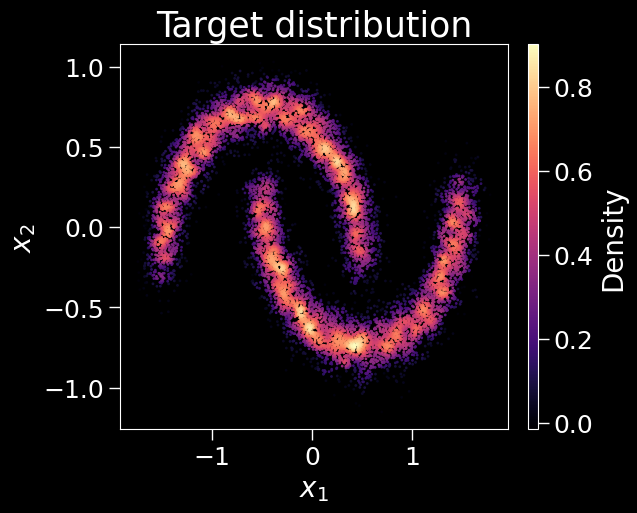

In [3]:
sigma_x0 = 0.1
dist = two_moons(width=sigma_x0)

x = dist.sample([10000])
ax = density_scatter(x.cpu().numpy(), s=1)
ax.set_title("Target distribution")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

Epoch 500 | Cost: 1.1e+00 |: 100%|██████████| 500/500 [07:53<00:00,  1.06it/s]

Finished training after 0.131 hours.


Text(0, 0.5, 'DSM loss')

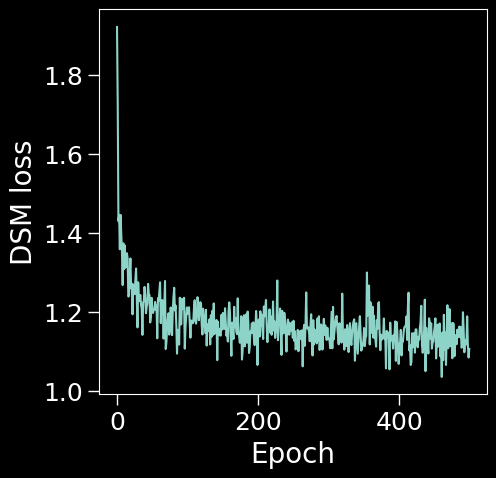

In [13]:
from score_models import ScoreModel, MLP

dataset = Dataset(dist)

hyperparameters = {
    "dimensions": 2,
    "units": 50,
    "layers": 4,
    "time_embedding_dimensions": 50,
    "embedding_scale": 32,
    "activation": "swish",
    "time_branch_layers": 1,
    "bottleneck": 15,
    "attention": True
}
net = MLP(**hyperparameters).to(DEVICE)
model = ScoreModel(model=net, sigma_min=1e-2, sigma_max=10)

# Define any preprocessing function if needed
def preprocessing_fn(x):
    return x

# Set the hyperparameters and other options for training
learning_rate = 1e-2
batch_size = 256
epochs = 500
ema_decay = 0.99
checkpoints_directory = "models"
checkpoints = 10 # save a checkpoint every 10 epochs
models_to_keep = 1 # only keep one model, erase previous ones
seed = 42

# Fit the model to the dataset
losses = model.fit(
    dataset,
    preprocessing_fn=preprocessing_fn,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    ema_decay=ema_decay,
    checkpoints_directory=checkpoints_directory,
    checkpoints=checkpoints,
    models_to_keep=models_to_keep,
    seed=seed
    )
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("DSM loss")

# Comparison with the true score

In [14]:
from torch.func import grad
from torch import vmap

def log_prob(t, x):
    width = torch.sqrt(sigma_x0**2 + model.sde.sigma(t)**2)
    return two_moons(width=width).log_prob(x)

def true_score(t, x):
    return vmap(grad(log_prob, argnums=1))(t, x)

Text(0, 0.5, 'True score')

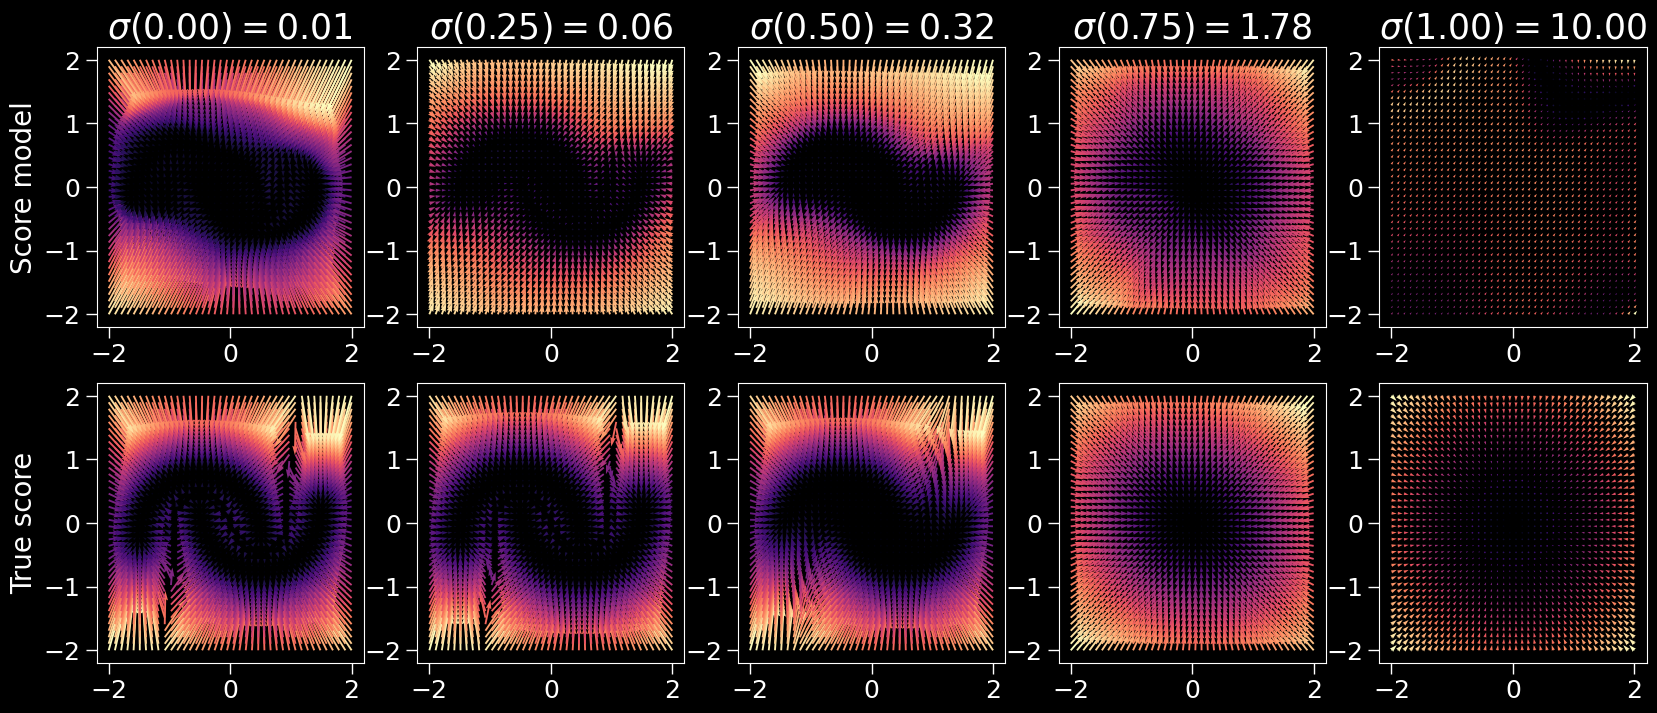

In [15]:
# Quality of the score field may vary on hyperparameters. More training generally helps.
# Trained with attention and bottleneck=15
fig, axs = plt.subplots(2, 5, figsize=(20, 8))


ts = [0, 0.25, 0.5, 0.75, 1]
scales = [1e3, 1e3, 1e2, 10, 1]
n = 40
dx = 0.01
xsize = 2
for i, t in enumerate(ts):
    ax1 = vector_field(lambda x: model(torch.ones(n**2).to(DEVICE)*t, x).cpu(), xmin=-xsize, xmax=xsize, ymin=-xsize, ymax=xsize, n=n, dx=dx, scale=scales[i], ax=axs[0, i])
    ax2 = vector_field(lambda x: true_score(torch.ones(n**2).to(DEVICE)*t, x).cpu(), xmin=-xsize, xmax=xsize, ymin=-xsize, ymax=xsize, n=n, dx=dx, scale=scales[i], ax=axs[1, i])
    ax1.set_title(f"$\sigma(%.2f) = %.2f$" % (t, model.sde.sigma(t)))

axs[0, 0].set_ylabel(r"Score model")
axs[1, 0].set_ylabel(r"True score")

# Sampling from the score model

100%|██████████| 100/100 [00:00<00:00, 456.41it/s]


(-1.0, 1.0)

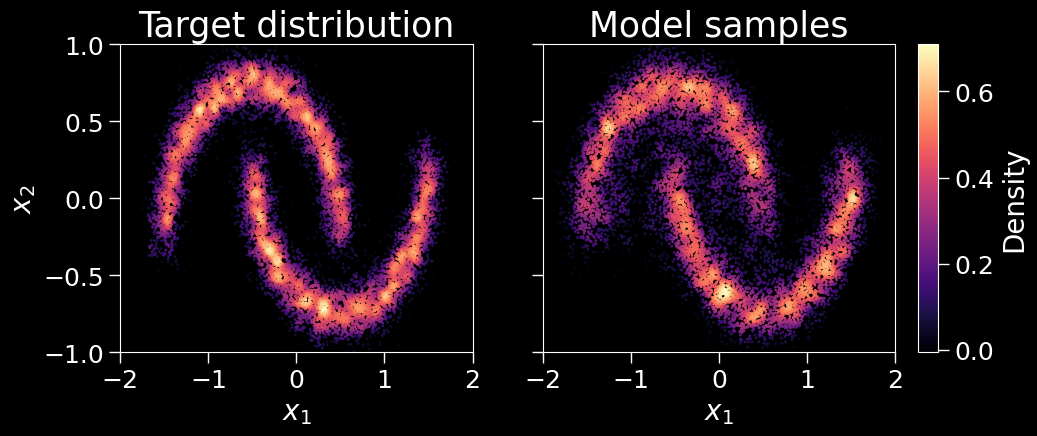

In [16]:
N = 100 # Number of Euler-Maruyama steps
samples = model.sample(size=[10000, 2], N=N)

dist = two_moons(width=sigma_x0)
x = dist.sample([10000])

xmax = 2
ymax = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1 = density_scatter(x.cpu().numpy(), ax=ax1, s=1)
ax1.set_title("Target distribution")
ax1.set_ylabel(r"$x_2$")
ax1.set_xlabel(r"$x_1$")
ax1.set_xlim(-xmax, xmax)
ax1.set_ylim(-ymax, ymax)


ax2 = density_scatter(samples.cpu().numpy(), fig=fig, ax=ax2, s=1)
ax2.set_title("Model samples")
ax2.set_xlabel(r"$x_1$")
ax2.set_xlim(-xmax, xmax)
ax2.set_ylim(-ymax, ymax)

# Training your Energy Model

Epoch 500 | Cost: 1.1e+00 |: 100%|██████████| 500/500 [04:18<00:00,  1.94it/s]

Finished training after 0.072 hours.


Text(0, 0.5, 'DSM loss')

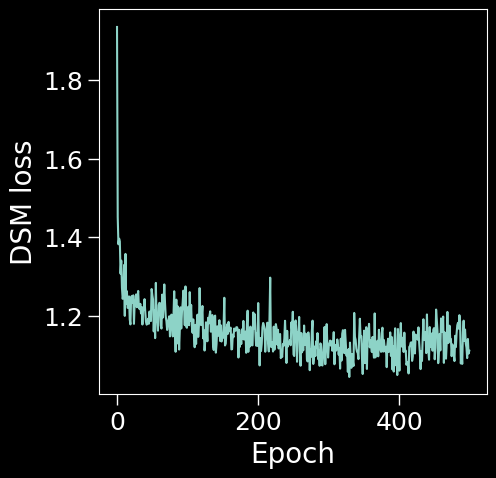

In [6]:
# The script follows the same structure as before
from score_models import EnergyModel, MLP

dataset = Dataset(dist)

hyperparameters = {
    "dimensions": 2,
    "units": 50,
    "layers": 2,
    "time_embedding_dimensions": 50,
    "embedding_scale": 32,
    "activation": "swish",
    "time_branch_layers": 1,
    "nn_is_energy": True,
    "bottleneck": 25,
    "attention": True
}
net = MLP(**hyperparameters).to(DEVICE)
model = EnergyModel(model=net, sigma_min=1e-2, sigma_max=10)

# Define any preprocessing function if needed
def preprocessing_fn(x):
    return x

# Set the hyperparameters and other options for training
learning_rate = 1e-2
batch_size = 256
epochs = 500
ema_decay = 0.99
checkpoints_directory = "models"
checkpoints = 10 # save a checkpoint every 10 epochs
models_to_keep = 1 # only keep one model, erase previous ones
seed = 42

# Fit the model to the dataset
losses = model.fit(
    dataset,
    preprocessing_fn=preprocessing_fn,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    ema_decay=ema_decay,
    checkpoints_directory=checkpoints_directory,
    checkpoints=checkpoints,
    models_to_keep=models_to_keep,
    seed=seed
    )
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("DSM loss")

In [19]:
from torch.func import grad
from torch import vmap

def log_prob(t, x):
    width = torch.sqrt(sigma_x0**2 + model.sde.sigma(t)**2)
    return two_moons(width=width).log_prob(x)

def true_score(t, x):
    return vmap(grad(log_prob, argnums=1))(t, x)

Text(0, 0.5, 'True score')

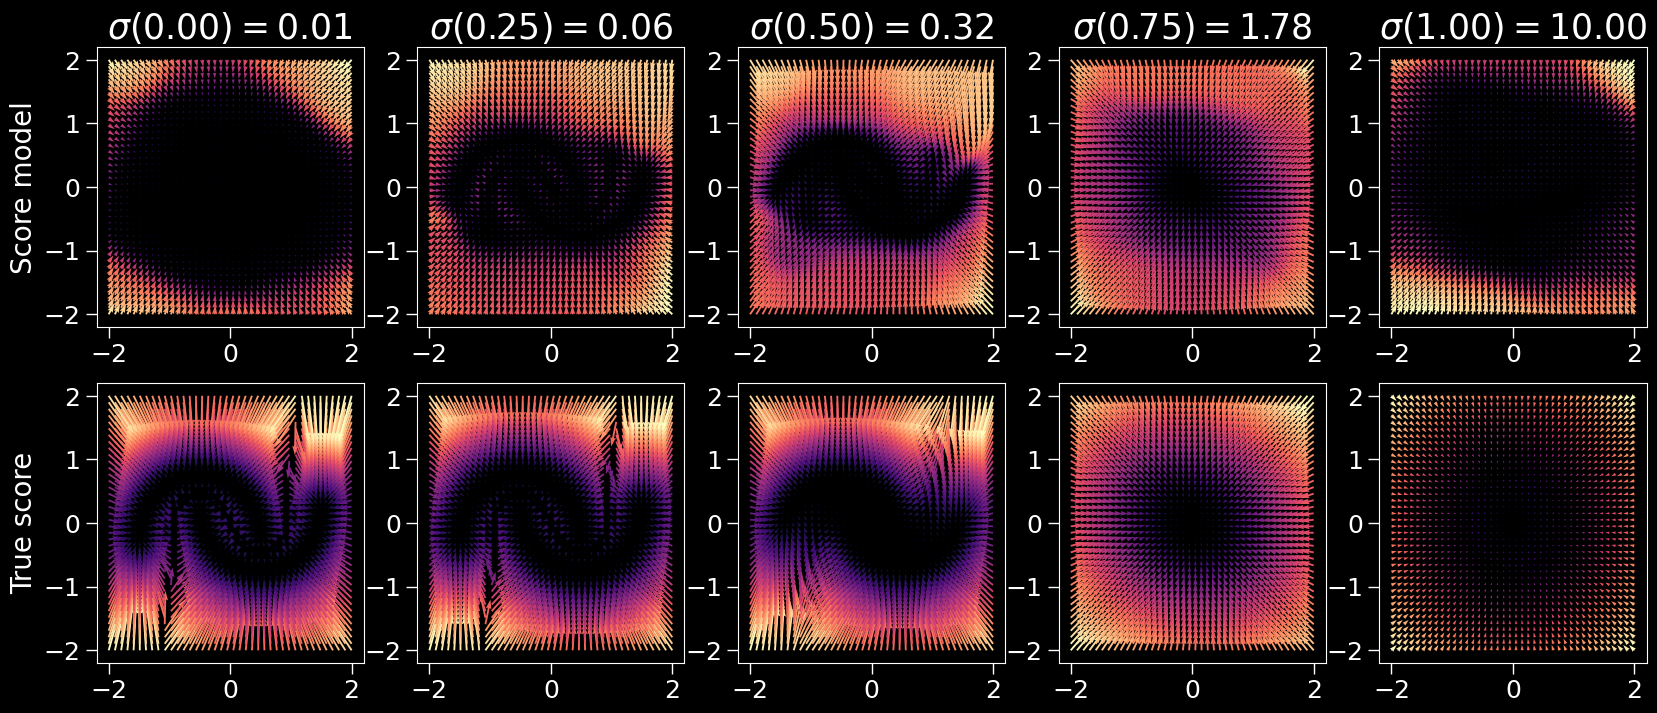

In [8]:
# Quality of the score field may vary on hyperparameters. More training generally helps.
fig, axs = plt.subplots(2, 5, figsize=(20, 8))


ts = [0, 0.25, 0.5, 0.75, 1]
scales = [1e3, 1e3, 1e2, 10, 1]
n = 40
dx = 0.01
xsize = 2
for i, t in enumerate(ts):
    ax1 = vector_field(lambda x: model(torch.ones(n**2).to(DEVICE)*t, x).cpu(), xmin=-xsize, xmax=xsize, ymin=-xsize, ymax=xsize, n=n, dx=dx, scale=scales[i], ax=axs[0, i])
    ax2 = vector_field(lambda x: true_score(torch.ones(n**2).to(DEVICE)*t, x).cpu(), xmin=-xsize, xmax=xsize, ymin=-xsize, ymax=xsize, n=n, dx=dx, scale=scales[i], ax=axs[1, i])
    ax1.set_title(f"$\sigma(%.2f) = %.2f$" % (t, model.sde.sigma(t)))

axs[0, 0].set_ylabel(r"Score model")
axs[1, 0].set_ylabel(r"True score")

Text(0, 0.5, 'True score')

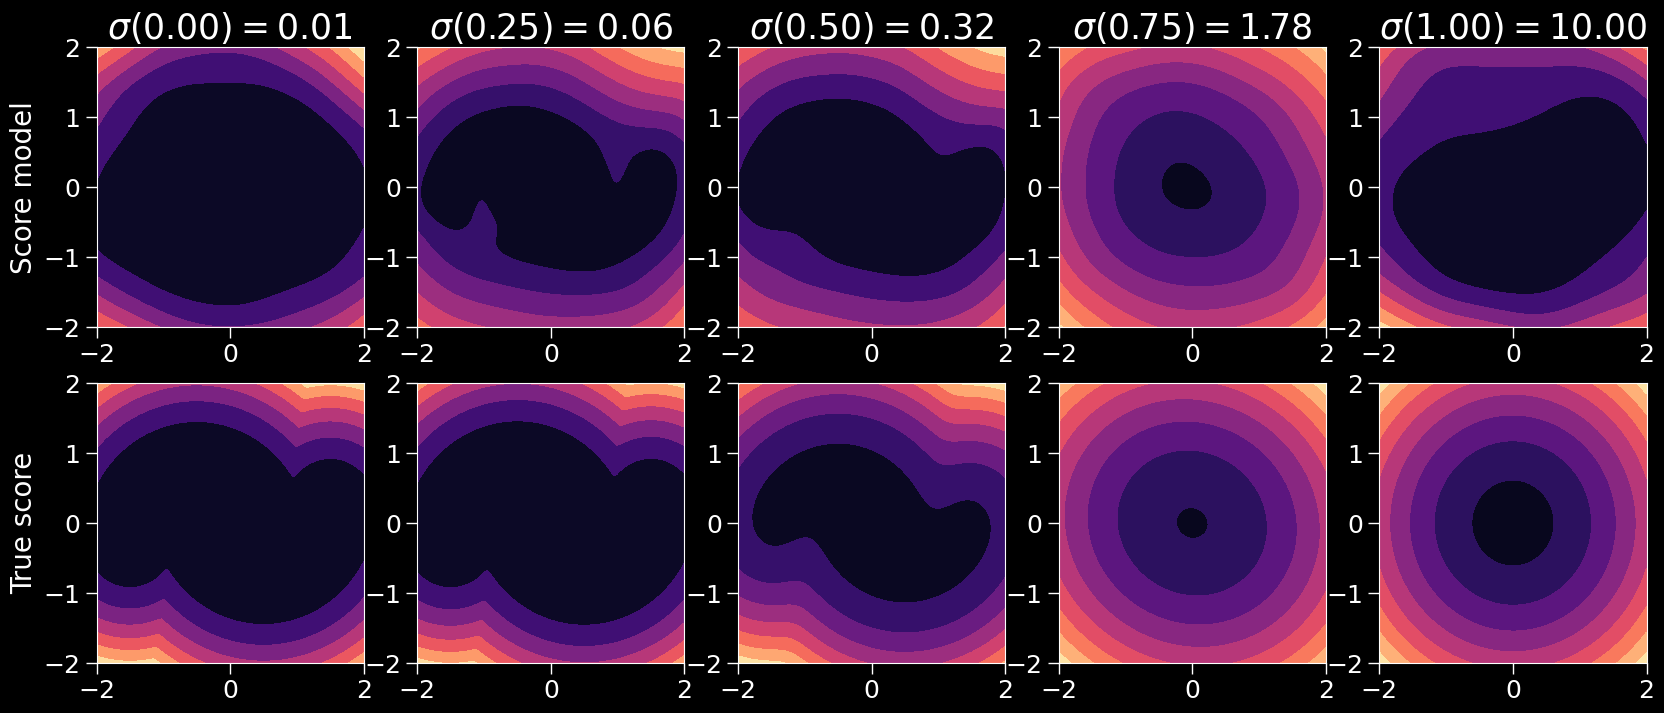

In [21]:
# Note that using the energy model, we have an energy function that can be used as well with regular MCMC algorithm
fig, axs = plt.subplots(2, 5, figsize=(20, 8))


ts = [0, 0.25, 0.5, 0.75, 1]
n = 100
xsize = 2
for i, t in enumerate(ts):
    ax1 = scalar_field(lambda x: model.energy(torch.ones(n**2).to(DEVICE)*t, x).cpu(), xmin=-xsize, xmax=xsize, ymin=-xsize, ymax=xsize, n=n, ax=axs[0, i])
    # Energy is associated with -logp
    ax2 = scalar_field(lambda x: - vmap(log_prob)(torch.ones(n**2).to(DEVICE)*t, x).cpu(), xmin=-xsize, xmax=xsize, ymin=-xsize, ymax=xsize, n=n, ax=axs[1, i])
    ax1.set_title(f"$\sigma(%.2f) = %.2f$" % (t, model.sde.sigma(t)))

axs[0, 0].set_ylabel(r"Score model")
axs[1, 0].set_ylabel(r"True score")

100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


(-1.0, 1.0)

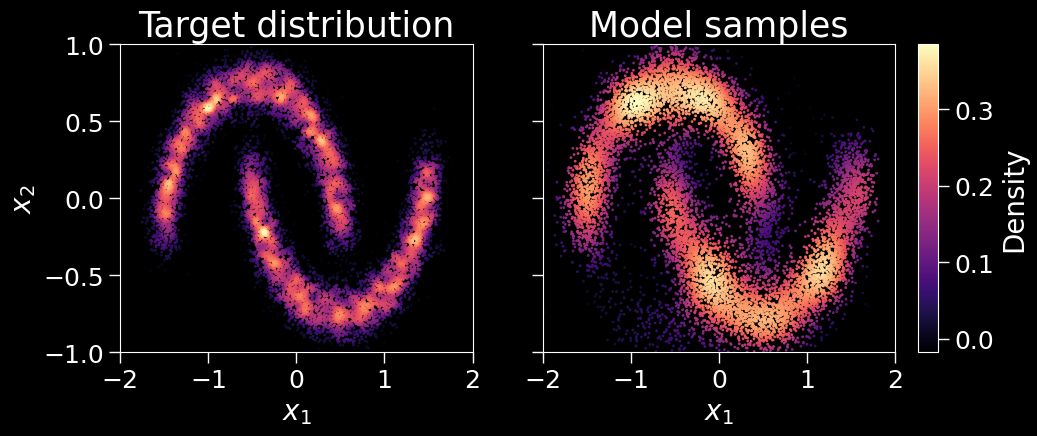

In [22]:
N = 100 # Number of Euler-Maruyama steps
samples = model.sample(size=[10000, 2], N=N)

dist = two_moons(width=sigma_x0)
x = dist.sample([10000])

xmax = 2
ymax = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1 = density_scatter(x.cpu().numpy(), ax=ax1, s=1)
ax1.set_title("Target distribution")
ax1.set_ylabel(r"$x_2$")
ax1.set_xlabel(r"$x_1$")
ax1.set_xlim(-xmax, xmax)
ax1.set_ylim(-ymax, ymax)


ax2 = density_scatter(samples.cpu().numpy(), fig=fig, ax=ax2, s=1)
ax2.set_title("Model samples")
ax2.set_xlabel(r"$x_1$")
ax2.set_xlim(-xmax, xmax)
ax2.set_ylim(-ymax, ymax)